In [36]:
!pip install gdown

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [37]:
!pip install wandb

# Downloading dataset (after preprocessing)

In [38]:
import gdown
url = "https://drive.google.com/uc?id="+ "1KOoXRPZxRRMkBSw2NQtsoOxVCXGK2g0B" #eeg data
gdown.download(url, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1KOoXRPZxRRMkBSw2NQtsoOxVCXGK2g0B
From (redirected): https://drive.google.com/uc?id=1KOoXRPZxRRMkBSw2NQtsoOxVCXGK2g0B&confirm=t&uuid=8baf1adc-f8ab-4e9f-8591-fcb0ebaae2d9
To: /kaggle/working/dataset_filter.pkl
100%|██████████| 1.02G/1.02G [00:05<00:00, 181MB/s]


'dataset_filter.pkl'

# Imports

In [39]:
import pandas as pd
import numpy as np
import scipy.io
import os

import re
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib as mpl

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Permute, Dropout, Lambda, Reshape
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import Add

from tensorflow.keras.layers import SeparableConv2D, DepthwiseConv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import SpatialDropout2D
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.layers import Normalization
from sklearn.model_selection import LeaveOneGroupOut

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Layer, Lambda
import tensorflow.keras.backend as K
from scipy import signal
import random


mpl.rcParams['figure.figsize'] = (10, 6)
mpl.rcParams['axes.grid'] = True
mpl.rcParams['legend.fontsize'] = 'large'


In [40]:
import wandb
from wandb.integration.keras import WandbMetricsLogger, WandbModelCheckpoint

wandb.login()

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

## Setting seed

In [41]:
seed_num = 15
np.random.seed(seed_num)
tf.random.set_seed(seed_num)


# Reading dataset through the downloaded pickle file

In [42]:
df = pd.read_pickle("dataset_filter.pkl")

## Splitting the subjects

In [43]:
n_tr_subj, n_test_subj = 9, 3
subjects = df['subject'].unique()
random.seed(15)
random.shuffle(subjects)
tr_subj = subjects[0:n_tr_subj]
test_subj = subjects[-n_test_subj:]

In [44]:
tr_subj

array(['H', 'A', 'F', 'G', 'I', 'B', 'L', 'K', 'C'], dtype=object)

In [45]:
test_subj

array(['E', 'M', 'J'], dtype=object)

In [46]:
def split_data_by_subjects(df,subjects):
  filtered_df = df[df['subject'].isin(subjects)]
  filtered_samples = filtered_df["data"].tolist()
  y = filtered_df["marker"].tolist()
  X = np.stack(filtered_samples, axis=0)[:, :, :, np.newaxis]
  del filtered_df
  del filtered_samples
  return X, y

## Dataframe including the subjects for training

In [47]:
train = df[df['subject'].isin(tr_subj)]

# Augmentation Layers Definition

In [48]:
def get_mean_variance(data):
    mean_per_channel = np.mean(data, axis=(0, 2, 3))
    var_per_channel = np.var(data, axis=(0, 2, 3)) #0,1,2 - windows 0,2,3
    
    return mean_per_channel, var_per_channel

## Channel Dropout

In [49]:
class ChannelDropout(Layer):
    def __init__(self, prob_aug=0.5, bandstop_width=0.4, **kwargs):
        super().__init__(**kwargs)
        self.prob_aug = prob_aug

    def random_channel_dropout(self, x):
        if tf.random.uniform(()) < self.prob_aug:
            prob_drop = 0.5
            uniform_samples = tf.random.uniform((21,), minval=0, maxval=1, dtype=tf.float32, seed=seed)
            mask_drop = tf.cast(uniform_samples > prob_drop, dtype=tf.int32)
            mask = tf.reshape(mask_drop, (21,1))
            return x * mask
        else:
            return x

    def call(self, x, training = None):
        if training:
            return self.random_channel_dropout(x)
        else:
            return x
    
    def compute_output_shape(self, input_shape):
        return input_shape

## Random Bandstop Filter

In [50]:
def notch_filtering(wav, fs, w0, Q):
    """ Apply a notch (band-stop) filter to the audio signal.

    Args:
        wav: Waveform.
        fs: Sampling frequency of the waveform.
        w0: The frequency to filter. See scipy.signal.iirnotch.
        Q: See scipy.signal.iirnotch.

    Returns:
        wav: Filtered waveform.
    """
    b, a = signal.iirnotch(w0,Q,fs)
    wav = signal.lfilter(b, a,wav)
    return np.ndarray.astype(wav, np.float32)

class RandomBandstopFilter(Layer):
    def __init__(self, prob=0.5, bandstop_width=0.4, **kwargs):
        super().__init__(**kwargs)
        self.prob = prob
        self.bandstop_width = bandstop_width

    def random_filter_signal(self, x):
        if tf.random.uniform(()) < self.prob:
            f_center = self.bandstop_width + tf.random.uniform(()) * (38 - 2 * self.bandstop_width)
            fs = 200
            w0 = f_center
            filtered_x = tf.numpy_function(notch_filtering,[x, fs, w0, self.bandstop_width],tf.float32)
            return filtered_x
        else:
            return x

    def call(self, x, training = None):
        if training:
            return self.random_filter_signal(x)
        else:
            return x
    
    def compute_output_shape(self, input_shape):
        return input_shape

## EEG Model definition

In [51]:
def EEGNet(nb_classes, train_mean= [0]*21, train_var = [1]*21,
           Chans = 64, Samples = 128,
             dropoutRate = 0.5, kernLength = 64, F1 = 16,
             D = 2, F2 = 32, norm_rate = 0.25, dropoutType = 'Dropout', activationFunction = "elu",
             avg_pool_1 = 4, avg_pool_2 = 8, bandstop_width = False, channel_dropout = False):
    """ 

    Inputs:

      nb_classes      : int, number of classes to classify
      Chans, Samples  : number of channels and time points in the EEG data
      dropoutRate     : dropout fraction
      kernLength      : length of temporal convolution in first layer. We found
                        that setting this to be half the sampling rate worked
                        well in practice. For the SMR dataset in particular
                        since the data was high-passed at 4Hz we used a kernel
                        length of 32.
      F1, F2          : number of temporal filters (F1) and number of pointwise
                        filters (F2) to learn. Default: F1 = 8, F2 = F1 * D.
      D               : number of spatial filters to learn within each temporal
                        convolution. Default: D = 2
      dropoutType     : Either SpatialDropout2D or Dropout, passed as a string.

    """

    if dropoutType == 'SpatialDropout2D':
        dropoutType = SpatialDropout2D
    elif dropoutType == 'Dropout':
        dropoutType = Dropout
    else:
        raise ValueError('dropoutType must be one of SpatialDropout2D '
                         'or Dropout, passed as a string.')

    input1   = Input(shape = (Chans, Samples, 1))
    
    if bandstop_width > 0:
        input1   = RandomBandstopFilter(bandstop_width)(input1)
    
    if channel_dropout:
        input1   = ChannelDropout()(input1)
    
    input1 = Normalization(axis = 1, mean = train_mean, variance = train_var)(input1)
    block1       = Conv2D(F1, (1, kernLength), padding = 'same',
                                   input_shape = (Chans, Samples, 1),
                                   use_bias = False,
                          )(input1)
    block1       = BatchNormalization()(block1)
    block1       = DepthwiseConv2D((Chans, 1), use_bias = False,
                                   depth_multiplier = D,
                                   depthwise_constraint = max_norm(1.))(block1)
    block1       = BatchNormalization()(block1)
    block1       = Activation(activationFunction)(block1)
    block1       = AveragePooling2D((1, avg_pool_1))(block1)
    block1       = dropoutType(dropoutRate)(block1)

    block2       = SeparableConv2D(F2, (1, 16),
                                   use_bias = False, padding = 'same')(block1)
    block2       = BatchNormalization()(block2)
    block2       = Activation(activationFunction)(block2)
    block2       = AveragePooling2D((1, avg_pool_2))(block2)
    block2       = dropoutType(dropoutRate)(block2)

    flatten      = Flatten(name = 'flatten')(block2)

    dense        = Dense(nb_classes, name = 'dense2',
                         kernel_constraint = max_norm(norm_rate))(flatten)
    softmax      = Activation('softmax', name = 'softmax')(dense)

    return Model(inputs=input1, outputs=softmax)

# Hyperparameters initialization

In [52]:
samples = 210
batch_size = 32
dropoutRate = 0.25
kernLength = 75
F1 = 32
D = 16
F2 = 64
activation = "relu"
optim_alg = "adam"
lr = 0.001
avg_pool_1 = 4
avg_pool_2 = 8
bandstop_width = 0.5
channel_dropout = True


In [53]:
def init_wandb(tr_subject, val_subject):
    wandb.init(   # set the wandb project where this run will be logged
    project="hda-eeg",
    config = {
        "architecture" : "EEGNet_v7",
        "comment": "210s sample",
        "convFilters_1" : F1,
        "convFilters_2" : F2,
        "depth_filters" : D,
        "samples" : samples,
        "dropoutRate" : dropoutRate,
        "kernLength" : kernLength,
        "activationFunction" : activation,
        "optimAlg" : optim_alg,
        "learningRate" : lr,
        "avgpooling_1": avg_pool_1,
        "avgpooling_2": avg_pool_2,
        "batchsize": batch_size,
        "bandstop_width":bandstop_width,
        "channel_dropout":channel_dropout,
        "train_subjects": tr_subject,
        "validation_subject": val_subject

    }
)


# Cross Validation (Leave One Out) definition

In [54]:
num_epochs = 20
early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=7)
accuracy_list = []
logo = LeaveOneGroupOut()

In [ ]:
for i, (train_index, val_index) in enumerate(logo.split(X=train['data'], y=train['marker'], groups=train['subject'])):
        print(f"Fold {i+1}:")

        train_group = np.unique(np.array(train['subject'])[train_index])
        val_group = np.unique(np.array(train['subject'])[val_index])
        print(f"  Train group={train_group}")
        print(f"  Validation group={val_group}")

        X_train, y_train = split_data_by_subjects(train,train_group)
        X_val, y_val = split_data_by_subjects(train,val_group)

        X_train = np.delete(X_train, 21, axis=2)
        y_train = np.array(y_train) - 1
        X_val = np.delete(X_val, 21, axis=2)
        y_val = np.array(y_val) - 1

        X_train = X_train.transpose((0,2,1,3))
        X_val = X_val.transpose((0,2,1,3))
        
        train_mean, train_variance = get_mean_variance(X_train)
        
        model_eegnet = EEGNet(nb_classes = 6, Chans = 21, Samples = samples,
                              dropoutRate = dropoutRate, kernLength = kernLength,
                              F1 = F1, F2 = F2, D = D,
                              activationFunction = activation,
                              avg_pool_1 = avg_pool_1, avg_pool_2=avg_pool_2, 
                              bandstop_width = bandstop_width,
                              train_mean = train_mean, train_var = train_variance)
        
        model_eegnet.compile(loss = "sparse_categorical_crossentropy", optimizer = "adam", 
                             metrics = ["accuracy"])
        
        init_wandb(train_group,val_group)    
        

        history = model_eegnet.fit(X_train, y_train,
                                    batch_size=batch_size,
                                    epochs=num_epochs,
                                    validation_data=(X_val, y_val),
                                    callbacks=[WandbMetricsLogger(log_freq=5),
                                               early_stop_callback],
                                    shuffle=True)
        accuracy_list.append(max(history.history['val_accuracy']))


#get average of accuracies over all cross folds
mean_accuracy = np.mean(accuracy_list)

# Mean accuracy over all folds

In [ ]:
mean_accuracy

# Training the model with better performance

In [57]:
samples = 210
batch_size = 32
dropoutRate = 0.25
kernLength = 75
F1 = 32
D = 16
F2 = 64
activation = "relu"
optim_alg = "adam"
lr = 0.001
avg_pool_1 = 4
avg_pool_2 = 8
bandstop_width = 1
channel_dropout = False


In [56]:
val = df[df['subject'].isin(test_subj)]

X_train, y_train = split_data_by_subjects(train,tr_subj)
X_val, y_val = split_data_by_subjects(val,test_subj)

X_train = np.delete(X_train, 21, axis=2)
y_train = np.array(y_train) - 1
X_val = np.delete(X_val, 21, axis=2)
y_val = np.array(y_val) - 1

X_train = X_train.transpose((0,2,1,3))
X_val = X_val.transpose((0,2,1,3))

train_mean, train_variance = get_mean_variance(X_train)

model_eegnet = EEGNet(nb_classes = 6, Chans = 21, Samples = samples,
                      dropoutRate = dropoutRate, kernLength = kernLength,
                      F1 = F1, F2 = F2, D = D,
                      activationFunction = activation,
                      avg_pool_1 = avg_pool_1, avg_pool_2=avg_pool_2, 
                      bandstop_width = bandstop_width,
                      train_mean = train_mean, train_var = train_variance)

model_eegnet.compile(loss = "sparse_categorical_crossentropy", optimizer = "adam", 
                     metrics = ["accuracy"])

init_wandb(train_group,val_group)    


history = model_eegnet.fit(X_train, y_train,
                            batch_size=batch_size,
                            epochs=num_epochs,
                            validation_data=(X_val, y_val),
                            callbacks=[WandbMetricsLogger(log_freq=5),
                                       early_stop_callback],
                            shuffle=True)

Epoch 1/20
656/656 ━━━━━━━━━━━━━━━━━━━━ 25s 30ms/step - accuracy: 0.3761 - loss: 1.5881 - val_accuracy: 0.5380 - val_loss: 1.2517
Epoch 2/20
656/656 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.5310 - loss: 1.2668 - val_accuracy: 0.5697 - val_loss: 1.1848
Epoch 3/20
656/656 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.5609 - loss: 1.1860 - val_accuracy: 0.5782 - val_loss: 1.1511
Epoch 4/20
656/656 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.5806 - loss: 1.1308 - val_accuracy: 0.5833 - val_loss: 1.1249
Epoch 5/20
656/656 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.5969 - loss: 1.0900 - val_accuracy: 0.5862 - val_loss: 1.1173
Epoch 6/20
656/656 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.6074 - loss: 1.0512 - val_accuracy: 0.5781 - val_loss: 1.1233
Epoch 7/20
656/656 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.6187 - loss: 1.0256 - val_accuracy: 0.5809 - val_loss: 1.1114
Epoch 8/20
656/656 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.6267 - loss: 1.0003 - val_acc

In [59]:
predicted = model_eegnet.predict(X_val)

209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


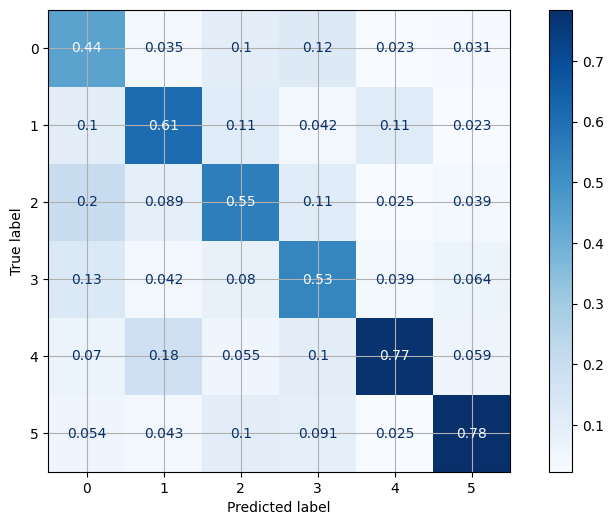

In [61]:
y_prediction = np.argmax (predicted, axis = 1)
cm = confusion_matrix(y_val, y_prediction, normalize='pred')
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

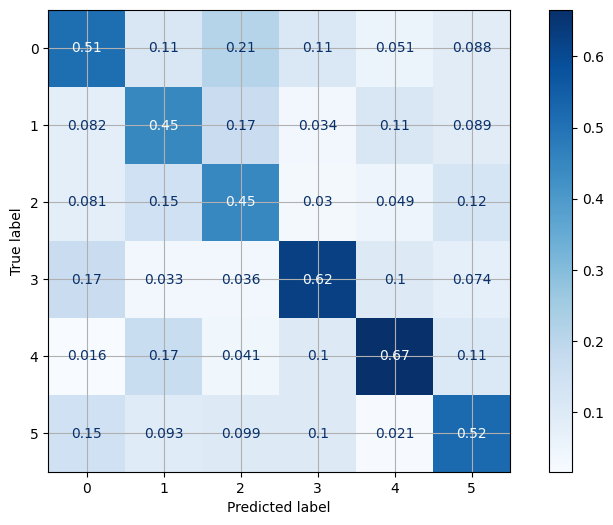

In [ ]:
y_prediction = np.argmax (predicted, axis = 1)
cm = confusion_matrix(y_val, y_prediction, normalize='pred')
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()